## dataの生成を行う

In [1]:

import json

with open("data/all_param_pre_data.json") as f:
    volume_param = json.load(f)

with open("data/all_price_param_data.json") as f:
    price_param = json.load(f)


In [2]:
volume_param

{'0x': {'p': 4,
  'a': [-0.3101947111430081,
   -0.19608226586922056,
   -0.19688207050584214,
   -0.10646877739196832],
  'const': 0.0022989742985026025,
  'omega': 0.21271402808274562,
  'b': 0.4529814093656944,
  'param_estimate_value': -0.054},
 '1inch': {'p': 6,
  'a': [-0.3977539303783955,
   -0.2973008688280114,
   -0.19122732686032026,
   -0.10684535085077952,
   -0.10315836591171423,
   -0.11515056728400172],
  'const': 0.004930291799628571,
  'omega': 0.16182911417123247,
  'b': 0.22324541957527758,
  'param_estimate_value': -0.001},
 'bakerytoken': {'p': 7,
  'a': [-0.2457165844581463,
   -0.26269629112870363,
   -0.22784160982974078,
   -0.2517472509323184,
   -0.1394629226575328,
   -0.15455985618017687,
   -0.08731057072034244],
  'const': 0.028781817129330606,
  'omega': 0.23869528036871346,
  'b': 0.18959915204390948,
  'param_estimate_value': 0.008},
 'aave': {'p': 4,
  'a': [-0.3593449272155587,
   -0.31688583022935507,
   -0.19971647337455262,
   -0.0731059422845795]

In [3]:
price_param

{'0x': {'a': 0.023539428865052992,
  'const': [0.03457680692930286],
  'omega': 1.358181807318826,
  'alpha': 0.012799652893279391,
  'beta': 0.9361183727976171,
  'rescale': 10,
  'param_estimate_value': 0.006},
 '1inch': {'a': 0.002155252777483798,
  'const': [0.05306893687077989],
  'omega': 3.5354691816206527,
  'alpha': 0.19340821469905364,
  'beta': 0.5679857453280573,
  'rescale': 10,
  'param_estimate_value': -0.006},
 'bakerytoken': {'a': 0.03872822626988396,
  'const': [-0.007306745943213258],
  'omega': 1.5354972288190145,
  'alpha': 0.07640165670513183,
  'beta': 0.909489232627773,
  'rescale': 10,
  'param_estimate_value': -0.015},
 'aave': {'a': 0.021815169473478193,
  'const': [-0.03794852381203129],
  'omega': 1.4298377296964369,
  'alpha': 0.02775844640070666,
  'beta': 0.8754581677217427,
  'rescale': 10,
  'param_estimate_value': 0.03},
 'aavegotchi': {'a': 0.0005306774146053532,
  'const': [0.04891244520031489],
  'omega': 0.43498124095151874,
  'alpha': 0.074426510

## モデルのパラメータを用いてデータの生成を行う

### volumeの生成関数

In [38]:
import numpy as np
import copy


def model_value(volume_info, price_info, length):
    volume_info["a"].reverse()
    volume_volatility = [np.random.normal(loc=0, scale=1)]
    price_volatility = [np.random.normal(loc=0, scale=1)]
    list_h = [0]
    temp_list = copy.deepcopy(volume_info["data"][-volume_info["p"]:])
    generated_volume_data = temp_list
    generated_price_data = [price_info["data"][-1]]
    for i in range(length):
        before_volume = generated_volume_data[-1]
        before_price = generated_price_data[-1]
        # volumeの計算
        x = 0
        for j in range(volume_info["p"]):
            x += generated_volume_data[i+j] * volume_info["a"][j] + volume_info["const"]
            if j == volume_info["p"]-1:
                x += before_price * volume_info["param_estimate_value"]
        volume_vol = (volume_info["b"] * volume_volatility[-1] + volume_info["omega"]) * np.random.normal(loc=0, scale=1) 
        x += volume_vol
        volume_volatility.append(volume_vol)
        generated_volume_data.append(x)
        # priceの計算
        y = 0
        y += generated_price_data[i] * price_info["a"] + price_info["const"]
        y += before_volume * price_info["param_estimate_value"]
        h = (price_info["omega"] + price_info["alpha"] * price_volatility[-1] + price_info["beta"] * list_h[-1]) / price_info["rescale"]
        price_vol = h * np.random.normal(loc=0, scale=1)
        y += price_vol
        price_volatility.append(price_vol)
        list_h.append(h)
        generated_price_data.append(y)

    return generated_volume_data[volume_info["p"]:], generated_price_data[1:]
    


In [21]:
import json

with open("data/all_formatted_pre_data.json") as f:
    coin_data = json.load(f)

In [124]:
def get_log_diff(data):
    # 対数を取り、差分を計算
    data = [n+0.000000001 for n in data]
    price_log = list(np.log(data))

    price_log_diff = []

    for i in range(len(price_log)-1):
        price_log_diff.append((price_log[i+1] - price_log[i]))

    return price_log_diff

In [45]:
volume_data = get_log_diff(coin_data["0x"]["volume"])
price_data = get_log_diff(coin_data["0x"]["price"])

In [120]:
volume_info = {
    "const" : volume_param["0x"]["const"],
    "p" : volume_param["0x"]["p"],
    "a" : volume_param["0x"]["a"],
    "omega": volume_param["0x"]["omega"],
    "b": volume_param["0x"]["b"],
    "param_estimate_value": volume_param["0x"]["param_estimate_value"],
    "data": volume_data,
}

price_info = {
    "a": price_param["0x"]["a"],
    "const": price_param["0x"]["const"][0],
    "omega": price_param["0x"]["omega"],
    "alpha": price_param["0x"]["alpha"],
    "beta": price_param["0x"]["beta"],
    "rescale": price_param["0x"]["rescale"],
    "param_estimate_value": price_param["0x"]["param_estimate_value"],
    "data": price_data
}


In [128]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

save_data = defaultdict(list)
error_key = []

for key in coin_data.keys():
    if (key in coin_data and key in volume_param):
        volume_data = get_log_diff(coin_data[key]["volume"])
        price_data = get_log_diff(coin_data[key]["price"])
        volume_info = {
            "const" : volume_param[key]["const"],
            "p" : volume_param[key]["p"],
            "a" : volume_param[key]["a"],
            "omega": volume_param[key]["omega"],
            "b": volume_param[key]["b"],
            "param_estimate_value": volume_param[key]["param_estimate_value"],
            "data": volume_data,
        }
        price_info = {
            "a": price_param[key]["a"],
            "const": price_param[key]["const"][0],
            "omega": price_param[key]["omega"],
            "alpha": price_param[key]["alpha"],
            "beta": price_param[key]["beta"],
            "rescale": price_param[key]["rescale"],
            "param_estimate_value": price_param[key]["param_estimate_value"],
            "data": price_data
        }
        volume_gene, price_gene = model_value(volume_info, price_info, 100+volume_info["p"])
        volume_scale_ratio = np.std(volume_data)/np.std(volume_gene)
        price_scale_ratio = np.std(price_data)/np.std(price_gene)
        volume_rescale_gene = [n*volume_scale_ratio for n in volume_gene][volume_info["p"]:]
        price_rescale_gene = [n*price_scale_ratio for n in price_gene][volume_info["p"]:]
        save_data[key] = {"volume": volume_rescale_gene, "price": price_rescale_gene}
    else:
        error_key.append(key)




In [144]:
save_data

defaultdict(list,
            {'0x': {'volume': [-0.06420335415838016,
               1.0250134567315796,
               -0.11238715883041912,
               -0.8788978465522979,
               -0.0125096951308386,
               0.48548914725126896,
               -0.2869742689778503,
               0.311979808191819,
               -0.0052835829140580335,
               0.22399399148080093,
               -0.14974200417132977,
               0.14696156774951494,
               -0.0402887540947103,
               0.043563345820753975,
               -0.2135051738014218,
               0.22439420778220762,
               -0.45870973214307187,
               0.4006026312063393,
               -0.1038634527112512,
               -0.6676661055869609,
               0.053612051000818846,
               -0.06189617341432563,
               0.5471498078191299,
               -0.15165419218435336,
               -0.4732125237756351,
               0.0005602672105784793,
               0.31975

In [134]:
with open("data/all_ans_data.json", "w") as file:
    json.dump(save_data, file, indent=4)

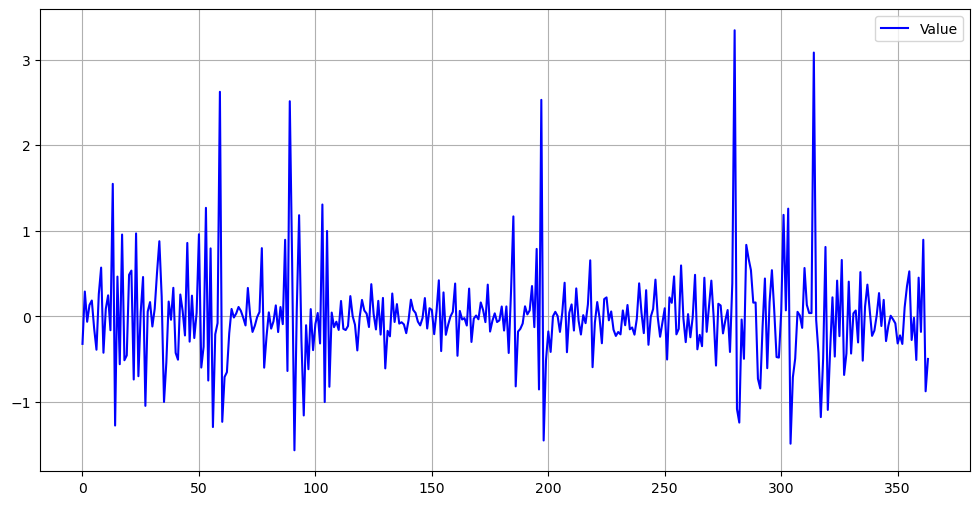

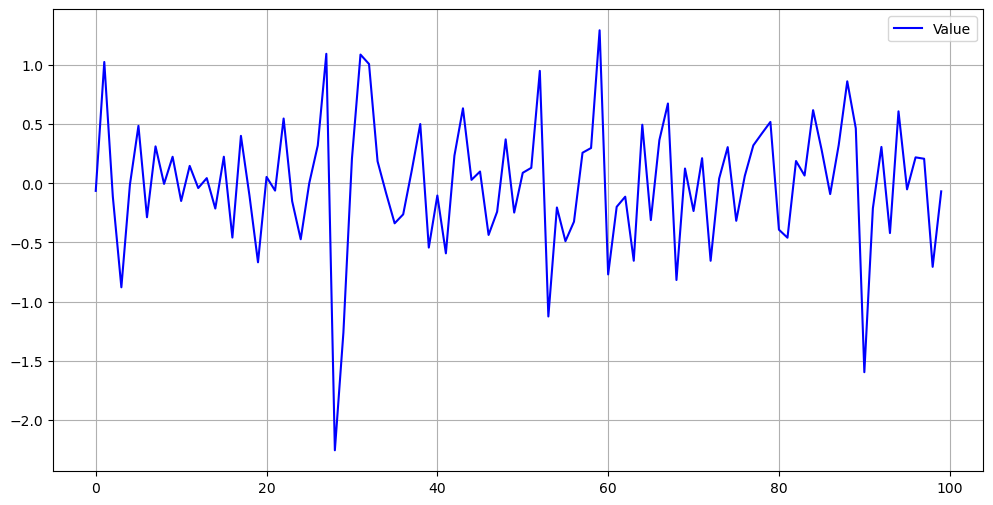

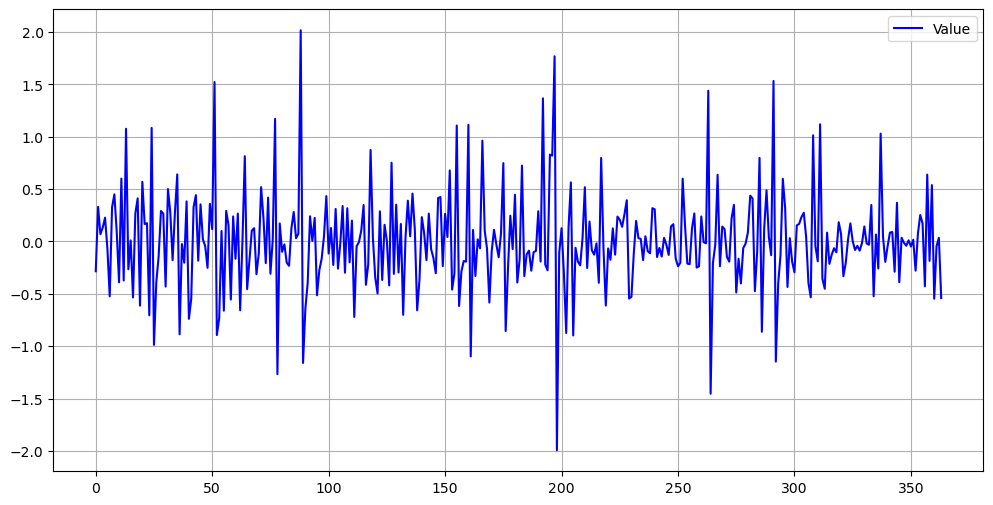

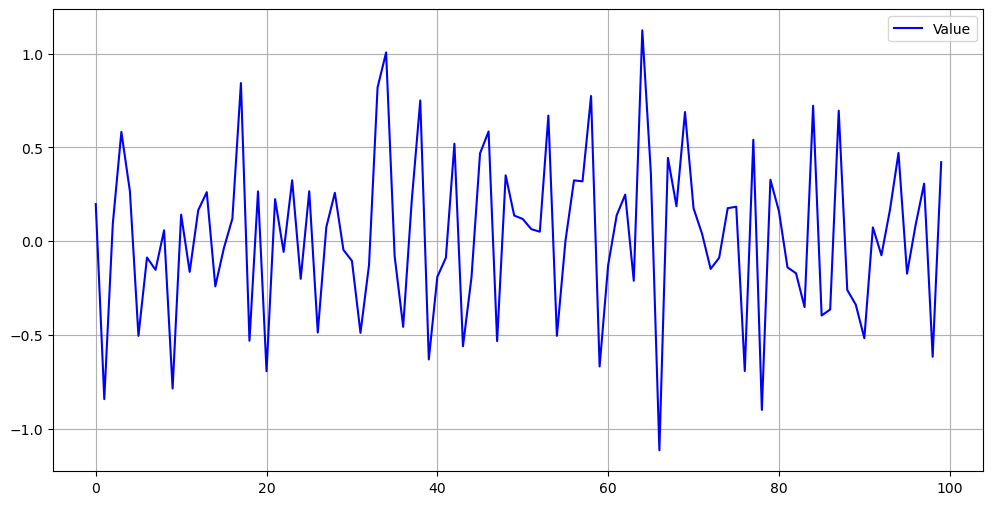

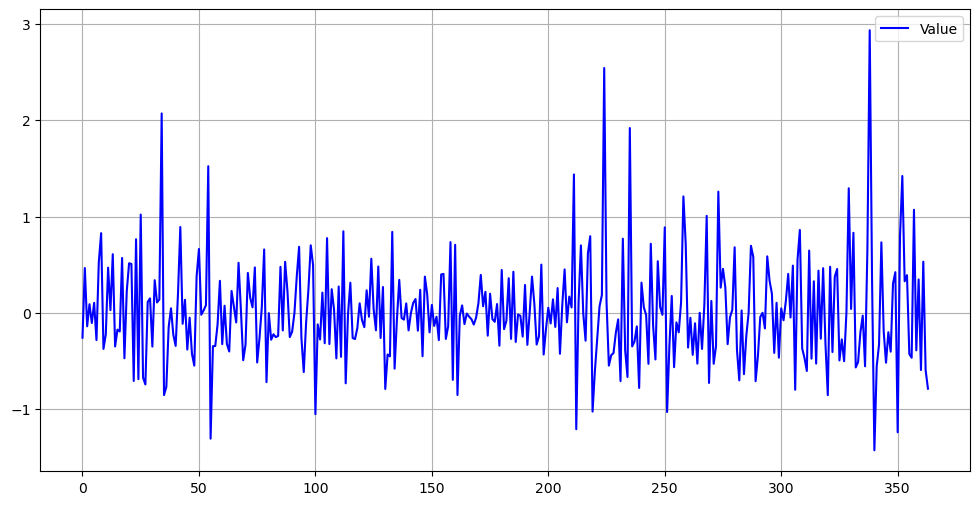

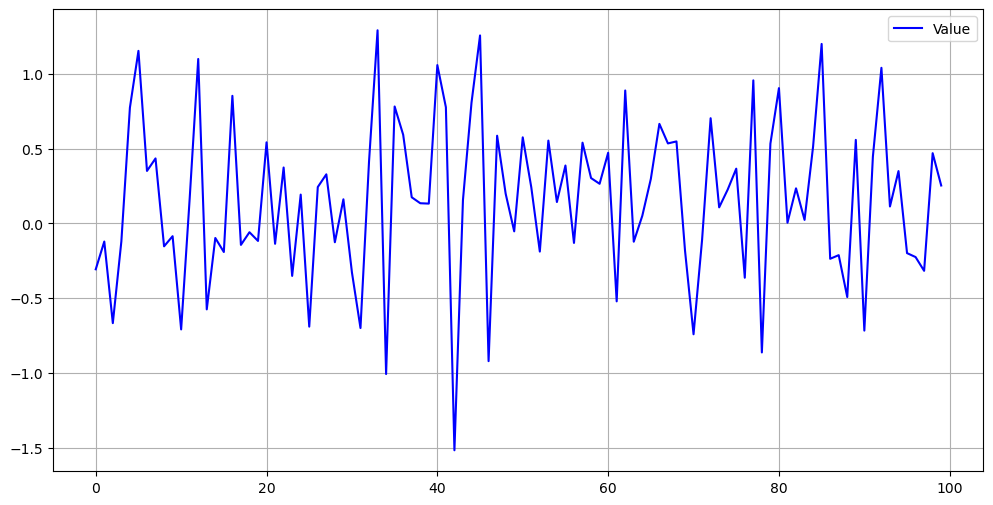

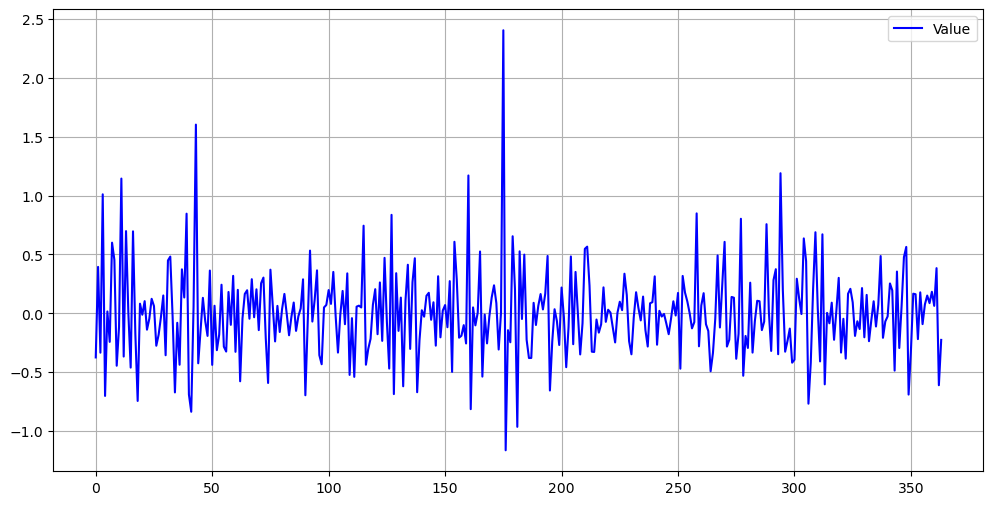

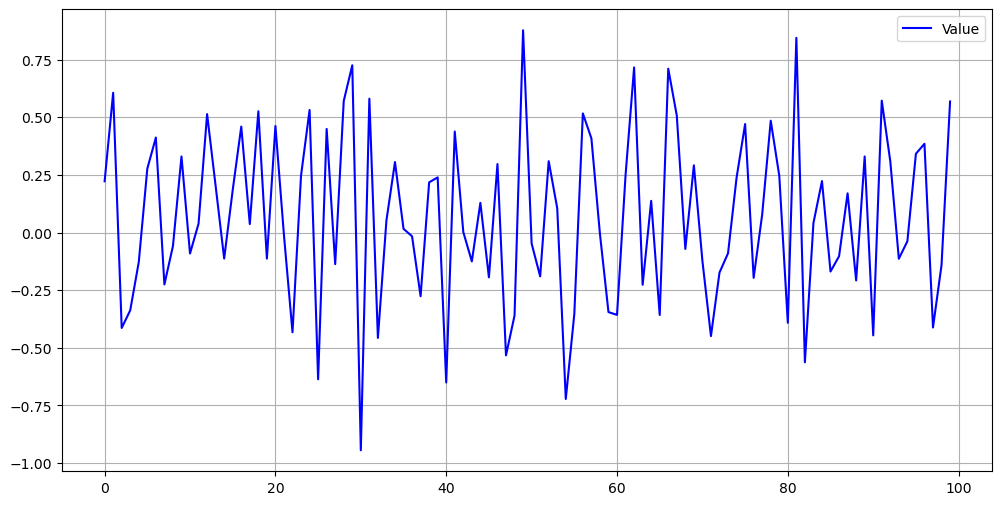

In [141]:
import matplotlib.pyplot as plt


for i, key in enumerate(coin_data.keys()):
    # 時系列データのプロット
    plt.figure(figsize=(12, 6))
    plt.plot([i for i in range(len(coin_data[key]["volume"])-1)], get_log_diff(coin_data[key]["volume"]), label='Value', color='b')  # 'Value'はプロットしたいカラム名
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot([i for i in range(len(save_data[key]["volume"]))], save_data[key]["volume"], label='Value', color='b')  # 'Value'はプロットしたいカラム名
    plt.legend()
    plt.grid(True)
    plt.show()
    if i > 2:
        break

In [96]:
volume_gene, price_gene = model_value(volume_info, price_info, 100+volume_info["p"])

In [98]:
len(volume_gene[volume_info["p"]:])

100

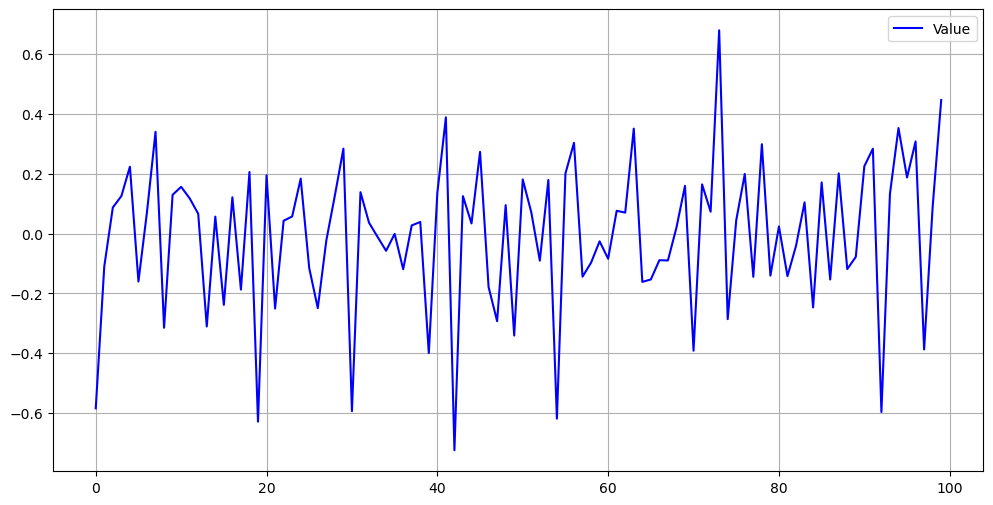

In [71]:
import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(volume_gene[volume_info["p"]:]))], volume_gene[volume_info["p"]:], label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()

In [100]:
len(price_gene[volume_info["p"]:])

100

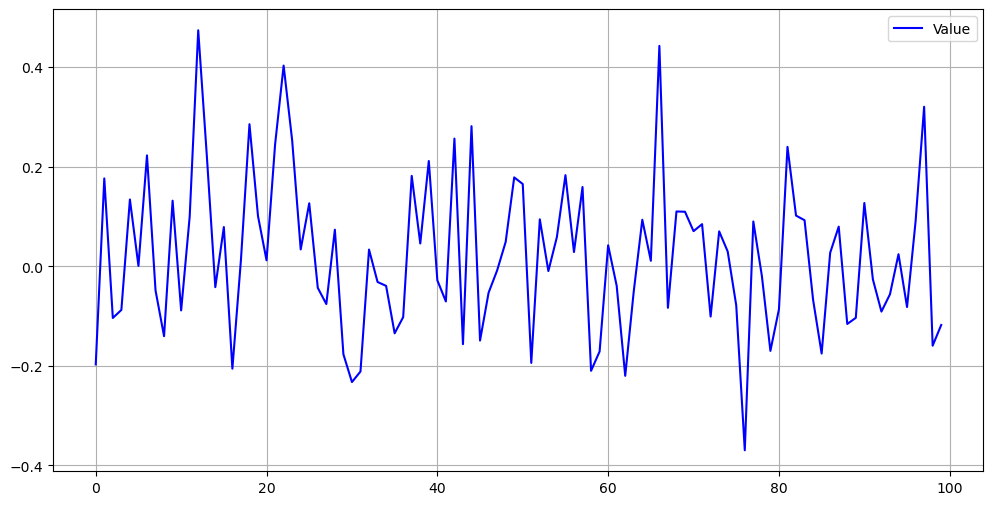

In [75]:
import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(price_gene[volume_info["p"]:]))], price_gene[volume_info["p"]:], label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()